In [37]:
from src.eeg import EEG, SET, epoch, ms, np, struct
from src.core import REc as rec
from src.data_legacy import band
from src.connectivity import preprocess, connectivity_analysis, phaselock, phaselag, spectral_coherence, PEC, cross_correlation, PAC
from src.tools import exclude_from_sz_cm 
from os import makedirs

In [38]:
main_folder = "/home/kivi/gdrive/epigame-folder/"

In [39]:
woi = input("Time window:\n 1. Non-seizure (baseline)\n 2. Pre-seizure (5 min prior to seizure)\n 3. Pre-seizure (4 min prior to seizure)\n 4. Pre-seizure (3 min prior to seizure)\n 5. Pre-seizure (2 min prior to seizure)\n 6. Pre-seizure (1 min prior to seizure)\n 7. Transition to seizure (1 min interval)\n 8. Transition to seizure (2 min interval)\n 9. Transition to seizure (60% seizure length interval)\n 10. Seizure\n Indicate a number: ")

method_idx = input("Connectivity method:\n 1. PEC\n 2. Spectral Coherence\n 3. Phase Lock Value\n 4. Phase-Lag Index\n 5. Cross-correlation\n 6. Phase-amplitude coupling\n Indicate a number: ")

ext = ""
if "2" == method_idx: 
    im = input("Imaginary part (Y/N): ").upper()
    if im == "Y": imag,ext = True,"I"
    elif im == "N": imag,ext = False,"R"

bands, Bands = input("Filter the signal: Y/N ").upper(), False

if bands=="N": bands = "w"
elif bands=="Y": 
    Bands = True
    mn = int(input("Set band range min: "))
    mx = int(input("Set band range max: "))
    bands = (mn,mx)

method_code = {'1':"PEC", '2':"SC_", '3':"PLV", '4':"PLI", '5':"CC", '6':"PAC"}   
woi_code = {'1':"baseline", '2':"preseizure5", '3':"preseizure4", '4':"preseizure3", '5':"preseizure2", '6':"preseizure1", '7':"transition1", '8':"transition2", '9':"transition60", '10':"seizure"}

##### Defining path to the EDF file. Filename format should be: patientacronym*-baseline.EDF or patientacronym*-seizure.EDF (asterix signifies a regular expression for any string of choice).
##### Subject identifier is saved as a three-letter acronym. 

In [40]:
file_baseline = main_folder + "data/ASJ2016APR14-PAc-baseline.EDF"
file_seizure = main_folder + "data/ASJ2016APR14-PAc-seizure.EDF"

subject_id = file_seizure.split("/")[-1][0:3]
print("Subject ID:", subject_id)

Subject ID: ASJ


##### Connectivity will be measured in epochs of data and later classified between baseline and a window of interest (WOI).
##### The WOI is fragmented into epochs of 1 second (span), with half-second overlaps (step). 
##### To keep the dataset balanced, we considered a fixed number of epochs, irregardless of the WOI duration. This number was fixed to 119 epochs (60/0.5-1), which covers a 1-minute window using the pre-set span and step parameters. 

In [41]:
span, step = 1000, 500      # in ms
min_woi_duration = 60000    # in ms
n_epochs = int((min_woi_duration/step)-1)

print("Number of epochs to consider for classification =", n_epochs)

eeg_seizure = EEG.from_file(file_seizure, epoch(ms(step), ms(span)))    # load raw seizure SEEG data as an EEG object (class) 
eeg_baseline = EEG.from_file(file_baseline, epoch(ms(step), ms(span)))   # load raw baseline SEEG data as an EEG object (class) 

Number of epochs to consider for classification = 119


##### Consult the clinical annotations.

In [42]:
print("Seizure file annotations:\n\n", [note for note in eeg_seizure.notes])
print("\nBaseline file annotations:\n\n", [note for note in eeg_baseline.notes])

Seizure file annotations:

 ['theta J13-15', 'Started Analyzer - Data Trends', 'Started Analyzer - XLEvent / ECG', 'LAFA A12-B12-C12', 'Montage:JUAN AGUSTIN SIERRA BIPOLAR (CON PLOT)', 'aplanamiento A,B, C,T, D, E, L', 'AUTOMATISMOS ORALES OROALIMENTARIOS', 'clÃ\xadnica hipermotora', 'evol. beta-alfa', 'Started Analyzer - CSA', 'empieza posiciÃ³n distÃ³nica', 'EEG inicio', 'rotaciÃ³n sobre el propio eje', 'act. rapida LAFA en T5, D3-6, E3-6', 'ASJ2016APR14-PAc', 'XLSpike', 'giro oculocefÃ¡lico no forzado hacia la izquierda', 'parpadeo rÃ\xadtmico', 'despertar, busca algo?', 'CLIP NBOA', 'theta P8-10, G8-10', 'theta J1-O1-F12, alfa F10-13', 'Started Analyzer - XLEvent - Intracranial', 'para la acciÃ³n', 'XLEvent', 'EEG fin']

Baseline file annotations:

 ['Started Analyzer - CSA', 'Montage:JUAN AGUSTIN SIERRA BIPOLAR (TTL)', 'Started Analyzer - Data Trends', 'Started Analyzer - XLEvent / ECG', 'mitad-NS', 'ASJ2016APR14-PAc-NS', 'Started Analyzer - XLEvent - Intracranial', 'NS-fin', 'XLS

##### Check file duration.

In [43]:
print("Seizure file duration:", eeg_seizure.duration)
print("Baseline file duration:", eeg_baseline.duration)

Seizure file duration: 702 s
Baseline file duration: 608 s


##### Check nodes.

In [44]:
# TODO: The code below is not redundant, double check for each patient and create a redundant version

nodes_seizure = list(eeg_seizure.axes.region)
nodes_baseline = list(eeg_baseline.axes.region)

nodes=[]
missing_node_ids=[]
extra_nodes_in = None

if nodes_seizure==nodes_baseline: nodes = nodes_seizure
else:
    if len(nodes_seizure)>len(nodes_baseline): 
        extra_nodes_in = "seizure"
        missing_nodes, nodes = [node for node in nodes_seizure if node not in nodes_baseline], nodes_seizure
        for missing in missing_nodes: 
            print(f"Node {missing} removed from seizure file as not present in baseline file.")
            missing_node_ids.append(nodes.index(missing))
            del nodes[nodes.index(missing)]
            eeg_seizure.axes.region.remove(missing)
    
    elif len(nodes_seizure)<len(nodes_baseline): 
        extra_nodes_in = "baseline"
        missing_nodes, nodes = [node for node in nodes_baseline if node not in nodes_seizure], nodes_baseline
        for missing in missing_nodes: 
            for missing in missing_nodes: 
                print(f"Node {missing} removed from baseline file as not present in seizure file.")
                missing_node_ids.append(nodes.index(missing))
                del nodes[nodes.index(missing)]
                eeg_baseline.axes.region.remove(missing)

print("\nFiles now have the same nodes:", nodes_seizure==nodes_baseline)
print("Number of nodes =", len(nodes))
print(nodes)

Node J9-J10 removed from seizure file as not present in baseline file.

Files now have the same nodes: True
Number of nodes = 98
['P1-P2', 'P4-P5', 'P8-P9', 'P9-P10', 'P10-P11', 'G1-G2', 'G8-G9', 'G9-G10', 'G10-G11', 'G11-G12', 'M1-M2', 'M8-M9', 'M9-M10', 'M10-M11', 'M11-M12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'C1-C2', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'L1-L2', 'L2-L3', 'L5-L6', 'L6-L7', 'L7-L8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'J1-J

##### The raw signal will be resampled to 500 Hz.

In [45]:
# check sampling

if eeg_baseline.fs == 50 and eeg_seizure.fs == 50: 
    
    print("WARNING: The sampling frequency may have been incorrectly filed... Overwrite with data from subsmeta.xlsx table for now; check with Ale later")
    eeg_seizure._set(fs = 500)
    eeg_baseline._set(fs = 500)

print("Sampling freqency (seizure file) =", eeg_seizure.fs)
print("Sampling freqency (baseline file) =", eeg_baseline.fs)

fs_min = min(eeg_seizure.fs, eeg_baseline.fs)

# set the resampled frequency to 500 Hz if sampling is not already 512 Hz
resampling = 512 if fs_min==512 else 500

Sampling freqency (seizure file) = 500
Sampling freqency (baseline file) = 500


##### Label the non-seizure (baseline) and seizure epochs relative to the position of clinical annotations (seizure start, seizure end). WOI is always defined relative to the seizure start. The baseline data is labeled independently.
##### Baseline file has arbitrary annotations, "EEG inicio" in the middle point and "EEG fin" at the end. The annotations serve to split the recording into two halves, for computing the baseline connectivity change (change from the first half to the second half)

In [46]:
SET(eeg_seizure, _as='N')                      # N - baseline (non-seizure)
SET(eeg_seizure, 'EEG inicio', 'W')            # W - WOI
SET(eeg_seizure, 'EEG fin', 'S', epoch.END)    # S - seizure

SET(eeg_baseline, _as='N')
SET(eeg_baseline, 'mitad-NS', 'W')            # W - middle point
SET(eeg_baseline, 'NS-fin', 'S', epoch.END)    # S - terminal point (end of recording)

S at: [605.088 s]

##### Optimize the positions of epochs relative to the clinical annotations.

In [47]:
eeg_seizure.optimize()
eeg_seizure.remap()

eeg_baseline.optimize()
eeg_baseline.remap()

optimizing epoch position... best frame found at 0.000s with a mean delay of 0.000s
optimizing epoch position... best frame found at 0.000s with a mean delay of 0.000s


##### Save seizure duration as the number of epochs present between the clinical annotations of seizure start and end.

In [48]:
units = int((eeg_seizure.notes['EEG fin'][0].time - eeg_seizure.notes['EEG inicio'][0].time)*(span/step))
print("Seizure length =", units/2, "s")

Seizure length = 93.5 s


##### Introduce a virtual mask into the eeg object, which indicates the time window to which an epoch belongs to (baseline, WOI or seizure). WOI is defined relative to the seizure start.

In [49]:
if woi == "1":
    woi_start = -units
    woi_end = 0

elif woi in [str(n) for n in [2,3,4,5,6]]:
    woi_start = - int(woi_code[woi][-1])*n_epochs
    woi_end = - (int(woi_code[woi][-1])-1)*n_epochs

elif woi in [str(n) for n in [7,8]]:
    woi_start = - int(round(int(woi_code[woi][-1])*60/2))
    woi_end = - woi_start

elif woi == "9":
    woi_start = - int(round(units*.3))
    woi_end = - woi_start

elif woi == "10":
    woi_start = -1
    woi_end = 0

eeg_seizure.tag(('W', 'S'), W=range(int(woi_start),int(woi_end),1), S=range(0,-units,-1))

eeg_baseline.tag(('W', 'S'), W=range(int(woi_start),int(woi_end),1), S=range(0,-units,-1))

##### Fetch the WOI epochs.

In [ ]:
a, ai = eeg_seizure.sample.get('W', n_epochs)   
b, bi = eeg_baseline.sample.get('W', n_epochs)   
i = ai + bi                         
x = a + b                         
y = [0]*n_epochs + [1]*n_epochs

print("Total number of epochs (seizure + baseline) =", len(x))
print("Epoch shape =", a[0].shape)

import matplotlib.pyplot as plt
from random import randint

j = randint(0, n_epochs-1)
plt.figure(figsize=(3,3))
plt.plot(a[j][0])
plt.title("Epoch example (seizure file)")
plt.show()
plt.figure(figsize=(3,3))
plt.plot(b[j][0])
plt.title("Epoch example (baseline file)")
plt.show()

##### Resample data.

In [ ]:
pp_seizure = [preprocess(eeg_seizure, ep, resampling) for i,ep in enumerate(x)] 
print("Resampled to", pp_seizure[0].shape)

pp_baseline = [preprocess(eeg_baseline, ep, resampling) for i,ep in enumerate(x)] 
print("Resampled to", pp_baseline[0].shape)

Resampled to (99, 500)
Resampled to (99, 500)


##### Filter in the set frequency band, if needed.

In [ ]:
fpp_seizure = [band(e, bands, pp_seizure[0].shape[1]) for e in pp_seizure] if Bands else pp_seizure
fpp_baseline = [band(e, bands, pp_baseline[0].shape[1]) for e in pp_baseline] if Bands else pp_baseline

/tmp/ipykernel_1105866/4254448501.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cm = struct(x=np.array(x), y=np.array(y), i=np.array(i)) # initiating an object for storing a connecivity matrix with shape (x, y) and epoch indices


Connectivity Analysis: phaselag
0: completed 
1: completed 
2: completed 
3: completed 
4: completed 
5: completed 
6: completed 
7: completed 
8: completed 
9: completed 
10: completed 
11: completed 
12: completed 
13: completed 
14: completed 
15: completed 
16: completed 
17: completed 
18: completed 
19: completed 
20: completed 
21: completed 
22: completed 
23: completed 
24: completed 
25: completed 
26: completed 
27: completed 
28: completed 
29: completed 
30: completed 
31: completed 
32: completed 
33: completed 
34: completed 
35: completed 
36: completed 
37: completed 
38: completed 
39: completed 
40: completed 
41: completed 
42: completed 
43: completed 
44: completed 
45: completed 
46: completed 
47: completed 
48: completed 
49: completed 
50: completed 
51: completed 
52: completed 
53: completed 
54: completed 
55: completed 
56: completed 
57: completed 
58: completed 
59: completed 
60: completed 
61: completed 
62: completed 
63: completed 
64: completed 
65:

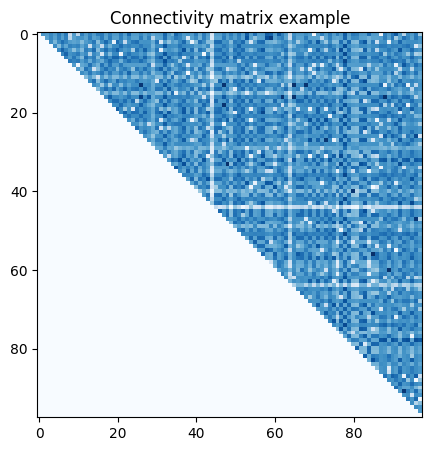

[[0.    0.604 0.572 ... 0.58  0.704 0.348]
 [0.    0.    0.548 ... 0.556 0.72  0.612]
 [0.    0.    0.    ... 0.64  0.644 0.604]
 ...
 [0.    0.    0.    ... 0.    0.652 0.612]
 [0.    0.    0.    ... 0.    0.    0.596]
 [0.    0.    0.    ... 0.    0.    0.   ]]
Seizure CM shape = (98, 98)
Baseline CM shape = (98, 98)


In [ ]:
cm = struct(x=np.array(x), y=np.array(y), i=np.array(i)) # initiating an object for storing a connecivity matrix with shape (x, y) and epoch indices

cm._set(nodes = nodes)

if method_code[method_idx] == "SC_":
    cm._set(X = connectivity_analysis(fpp_seizure, spectral_coherence, fs=fpp_seizure[0].shape[1], imag=imag))

elif method_code[method_idx] == "PEC": 
    cm._set(X = [PEC(ep,i+1) for i,ep in enumerate(fpp_seizure)])

elif method_code[method_idx] in "PLV":
    cm._set(X = connectivity_analysis(fpp_seizure, phaselock))

elif method_code[method_idx] == "PLI":
    cm._set(X = connectivity_analysis(fpp_seizure, phaselag))

elif method_code[method_idx] == "CC":
    cm._set(X = connectivity_analysis(fpp_seizure, cross_correlation))

elif method_code[method_idx] == "PAC":
    cm._set(X = connectivity_analysis(fpp_seizure, PAC, True, fpp_seizure[0].shape[1]))

if extra_nodes_in is not None:
    for m in missing_node_ids:
        print("Mismatched node index:", m)
        if extra_nodes_in=="seizure":
            cm.X = exclude_from_sz_cm(cm.X, m)

plt.figure(figsize=(5,5))
plt.imshow(cm.X[-1], cmap='Blues', interpolation='nearest')
plt.title("Connectivity matrix example")
plt.show()
print(cm.X[-1])

print("Seizure CM shape =", cm.X[0].shape)
print("Baseline CM shape =", cm.X[-1].shape)

In [ ]:
path_cm = main_folder + "connectivity_matrices/"
makedirs(path_cm, exist_ok=True)

if Bands:          rec(cm).save(path_cm + f"{subject_id}-{woi_code[woi]}-{method_code[method_idx]}{ext}-{bands}.prep".replace(" ","")) 
elif not Bands:    rec(cm).save(path_cm + f"{subject_id}-{woi_code[woi]}-{method_code[method_idx]}{ext}.prep") 